# Multi-fidelity BO
Here we demonstrate how Multi-Fidelity Bayesian Optimization can be used to reduce
the computational cost of optimization by using lower fidelity surrogate models. The
goal is to learn functional dependance of the objective on input variables at low
fidelities (which are cheap to compute) and use that information to quickly find the
best objective value at higher fidelities (which are more expensive to compute). This
assumes that there is some learnable correlation between the objective values at
different fidelities.

Xopt implements the MOMF (https://botorch.org/tutorials/Multi_objective_multi_fidelity_BO)
algorithm which can be used to solve both single (this notebook) and multi-objective
(see multi-objective BO section) multi-fidelity problems. Under the hood this
algorithm attempts to solve a multi-objective optimization problem, where one
objective is the function objective and the other is a simple fidelity objective,
weighted by the ```cost_function``` of evaluating the objective at a given fidelity.

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
N_RESTARTS = 1 if SMOKE_TEST else 20

import matplotlib.pyplot as plt
import numpy as np
import math

import pandas as pd
import torch

def test_function(input_dict):
    x = input_dict["x"]
    s = input_dict["s"]
    return {"f":np.sin(x + (1.0 - s)) * np.exp((-s+1)/2)}


# define vocs
from xopt import VOCS
vocs = VOCS(
    variables={
        "x": [0, 2*math.pi],
    },
    objectives={"f": "MINIMIZE"},
)

## plot the test function in input + fidelity space


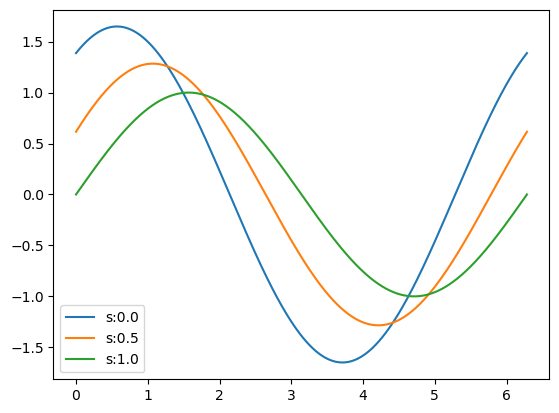

In [2]:
test_x = np.linspace(*vocs.bounds, 1000)
fidelities = [0.0,0.5,1.0]

fig,ax = plt.subplots()
for ele in fidelities:
    f = test_function({"x":test_x, "s":ele})["f"]
    ax.plot(test_x, f,label=f"s:{ele}")

ax.legend()

In [3]:
# create xopt object
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt import Evaluator, Xopt

# get and modify default generator options
generator = MultiFidelityGenerator(vocs=vocs)

# specify a custom cost function based on the fidelity parameter
generator.cost_function = lambda s: s + 0.001

generator.numerical_optimizer.n_restarts = N_RESTARTS
generator.n_monte_carlo_samples = N_MC_SAMPLES

# pass options to the generator
evaluator = Evaluator(function=test_function)

X = Xopt(vocs=vocs, generator=generator, evaluator=evaluator)
X


            Xopt
________________________________
Version: 0+untagged.1511.gf1c313f.dirty
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.test_function
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: multi_fidelity
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  reference_point:
    f: 100.0
    s: 0.0
  supports_batch_generation: true
  supports_multi_objective: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
st

In [4]:
# evaluate initial points at mixed fidelities to seed optimization
X.evaluate_data(pd.DataFrame({
    "x":[math.pi / 4, math.pi / 2., math.pi],"s":[0.0, 0.25, 0.0]
}))

,x,s,f,xopt_runtime,xopt_error
0,0.785398,0.00,1.610902,0.000011,False
1,1.570796,0.25,1.064601,0.000002,False
2,3.141593,0.00,-1.387351,0.000002,False


In [5]:
# get the total cost of previous observations based on the cost function
X.generator.calculate_total_cost()

tensor(0.2530, dtype=torch.float64)

In [6]:
# run optimization until the cost budget is exhausted
# we subtract one unit to make sure we don't go over our eval budget
budget = 10
while X.generator.calculate_total_cost() < budget - 1:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")


n_samples: 4 budget used: 0.6154 hypervolume: 35.99
n_samples: 5 budget used: 1.13 hypervolume: 51.01
n_samples: 6 budget used: 1.858 hypervolume: 72.15
n_samples: 7 budget used: 2.826 hypervolume: 96.06
n_samples: 8 budget used: 3.827 hypervolume: 100.9
n_samples: 9 budget used: 4.828 hypervolume: 100.9
n_samples: 10 budget used: 5.829 hypervolume: 100.9
n_samples: 11 budget used: 6.83 hypervolume: 100.9
n_samples: 12 budget used: 6.872 hypervolume: 100.9
n_samples: 13 budget used: 7.117 hypervolume: 101.1
n_samples: 14 budget used: 8.118 hypervolume: 101.1
n_samples: 15 budget used: 8.57 hypervolume: 101.1
n_samples: 16 budget used: 9.283 hypervolume: 101.2


In [7]:
X.data

,x,s,f,xopt_runtime,xopt_error
0,0.785398,0.000000,1.610902e+00,0.000011,False
1,1.570796,0.250000,1.064601e+00,0.000002,False
2,3.141593,0.000000,-1.387351e+00,0.000002,False
3,2.178075,0.361444,4.393617e-01,0.000007,False
4,1.505972,0.513500,1.163669e+00,0.000009,False
5,1.714896,0.726913,1.047989e+00,0.000009,False
6,2.165413,0.967190,8.229307e-01,0.000009,False
7,4.379269,1.000000,-9.450268e-01,0.000008,False
8,3.364829,1.000000,-2.213865e-01,0.000010,False
9,6.283185,1.000000,-2.449294e-16,0.000007,False


## Plot the model prediction and acquisition function inside the optimization space

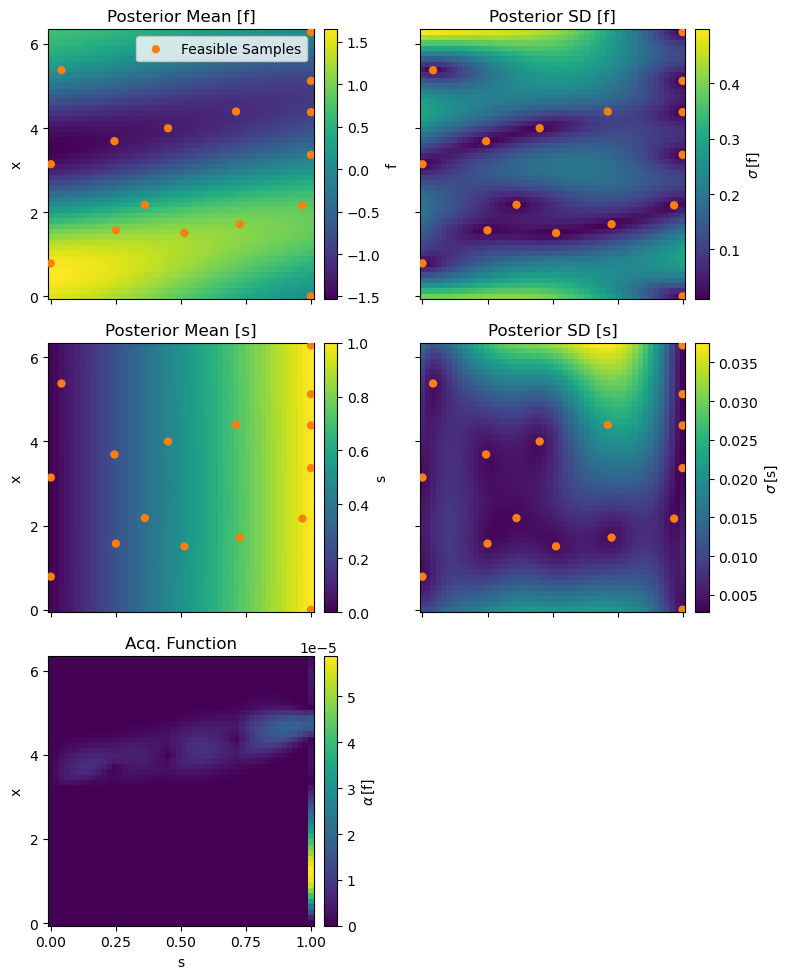

In [8]:
fig, ax = X.generator.visualize_model()

## Plot the Pareto front

<Axes: xlabel='f'>

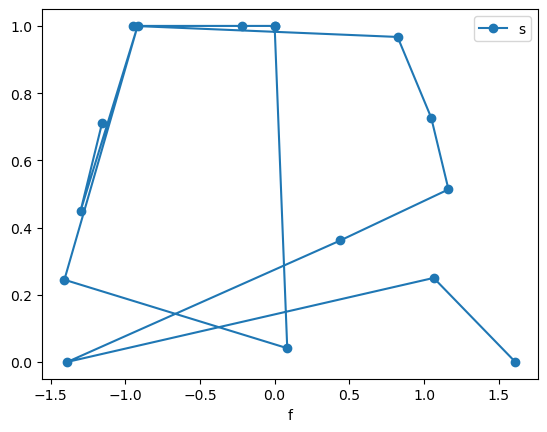

In [9]:
X.data.plot(x="f", y="s", style="o-")

In [10]:
X.data

,x,s,f,xopt_runtime,xopt_error
0,0.785398,0.000000,1.610902e+00,0.000011,False
1,1.570796,0.250000,1.064601e+00,0.000002,False
2,3.141593,0.000000,-1.387351e+00,0.000002,False
3,2.178075,0.361444,4.393617e-01,0.000007,False
4,1.505972,0.513500,1.163669e+00,0.000009,False
5,1.714896,0.726913,1.047989e+00,0.000009,False
6,2.165413,0.967190,8.229307e-01,0.000009,False
7,4.379269,1.000000,-9.450268e-01,0.000008,False
8,3.364829,1.000000,-2.213865e-01,0.000010,False
9,6.283185,1.000000,-2.449294e-16,0.000007,False


In [11]:
# get optimal value at max fidelity, note that the actual maximum is 4.71
X.generator.get_optimum().to_dict()

{'x': {0: 4.72645076013667}, 's': {0: 1.0}}